NNを元に2次関数の終端コストを決定


反復学習: イテレーション 1/5
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.00ms (151.52us)   6.60ms (199.97us)        33
       nlp_g  |   3.00ms ( 90.91us)   5.00ms (151.58us)        33
  nlp_grad_f  |   5.00ms (147.06us)  10.68ms (314.00us)        34
  nlp_hess_l  |  14.00ms (437.50us)  22.58ms (705.78us)        32
   nlp_jac_g  |   6.00ms (176.47us)  12.05ms (354.29us)        34
       total  | 383.00ms (383.00ms) 380.53ms (380.53ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.00ms (148.15us)   4.27ms (158.15us)        27
       nlp_g  |   9.00ms (333.33us)   2.99ms (110.70us)        27
  nlp_grad_f  |   5.00ms (178.57us)   7.73ms (276.25us)        28
  nlp_hess_l  |  14.00ms (538.46us)  15.91ms (611.81us)        26
   nlp_jac_g  |   8.00ms (285.71us)   8.16ms (291.36us)        28
       total  | 250.00ms (250.00ms) 249.82ms (249.82ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)  

 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in divide


GPR: 学習完了
NN: 終端コストの学習開始...
NN: 学習完了。最終損失: 5020.9751

反復学習: イテレーション 3/5
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 76.92us)   2.32ms (178.46us)        13
       nlp_g  |   2.00ms (153.85us)   1.53ms (117.77us)        13
  nlp_grad_f  |   3.00ms (214.29us)   4.29ms (306.57us)        14
  nlp_hess_l  |   7.00ms (583.33us)   8.28ms (690.33us)        12
   nlp_jac_g  |   4.00ms (285.71us)   4.60ms (328.57us)        14
       total  |  98.00ms ( 98.00ms) 100.03ms (100.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   2.61ms (200.62us)        13
       nlp_g  |        0 (       0)   1.98ms (152.23us)        13
  nlp_grad_f  |   5.00ms (357.14us)   4.93ms (352.07us)        14
  nlp_hess_l  |  18.00ms (  1.50ms)   9.57ms (797.25us)        12
   nlp_jac_g  |   1.00ms ( 71.43us)   5.54ms (395.71us)        14
       total  | 118.00ms (118.00ms) 107.61ms (107.61ms)         1
    

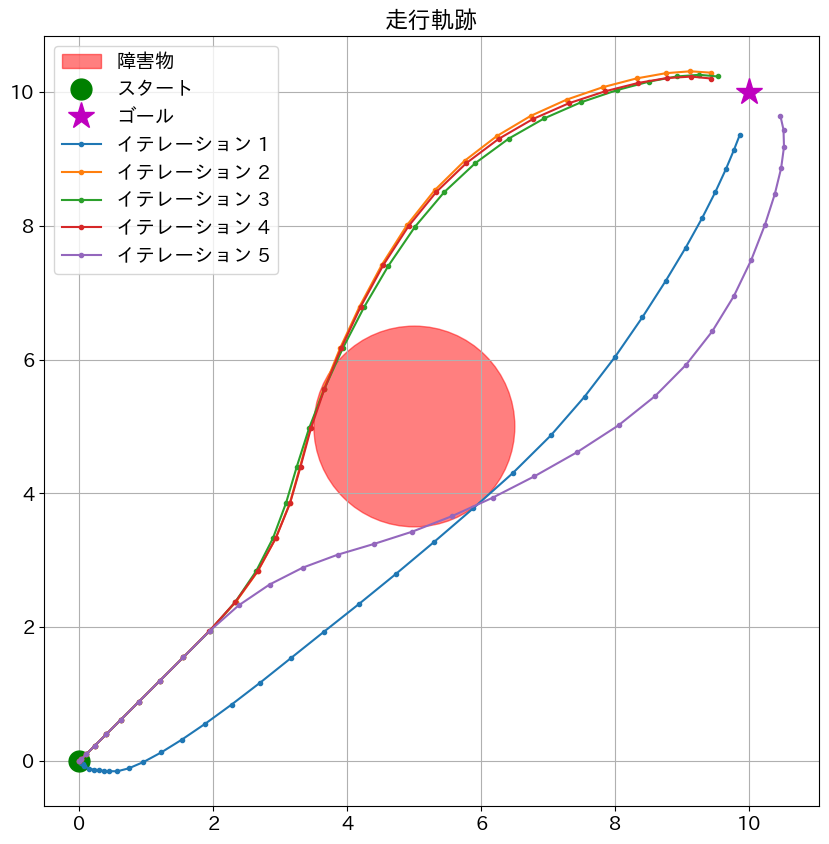

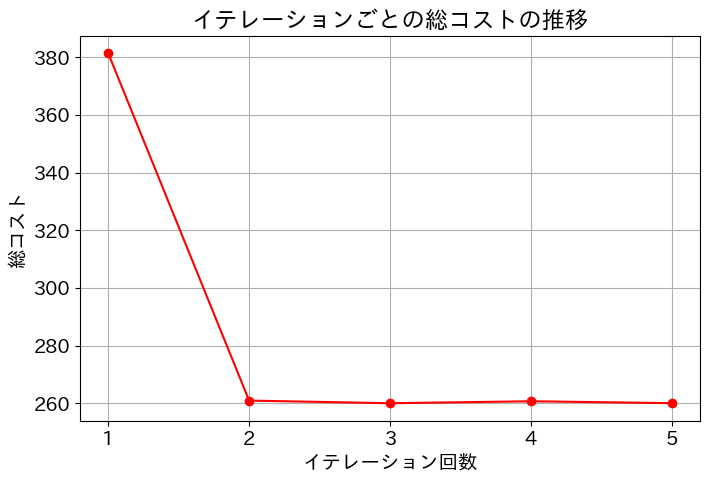

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import casadi as ca
import torch
import torch.nn as nn
import torch.optim as optim
import time


import japanize_matplotlib
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (8, 8)

# ==================================================================================
# シミュレーション全体の設定パラメータ
# ==================================================================================
N_ITERATIONS = 5
SIM_STEPS = 100
DT = 0.1
NX, NU = 4, 2
START_STATE = np.array([0.0, 0.0, 0.0, 0.0])
GOAL_STATE = np.array([10.0, 10.0])
N_MPC = 20
M_MPC = 25
OBSTACLE_INFO = {'pos': np.array([5.0, 5.0]), 'rad': 1.5}


# ----------------------------------------------------------------------------------
# TerminalCostNN & 学習関数
# ----------------------------------------------------------------------------------
class TerminalCostNN(nn.Module):
    def __init__(self, n_input):
        super(TerminalCostNN, self).__init__() #親クラスを初期化
        self.layers = nn.Sequential( #3層
            nn.Linear(n_input, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.layers(x)

def train_terminal_cost_net(net, trajectory_data): #costs_to_go(ある地点からゴールにたどり着くまでどのくらいのコストがかかるか)、未来の累積コストの予測値を学習、trajectory_data(軌道と各ステージのコスト)
    if len(trajectory_data) < 10: return #データが10個未満ならスキップ
    print("NN: 終端コストの学習開始...")
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    states = torch.tensor(np.array([d[0] for d in trajectory_data]), dtype=torch.float32)
    costs_to_go = []
    running_cost = 0
    for _, stage_cost in reversed(trajectory_data): #costs_to_goを終端から逆算して計算、最後のステップのコストから順に足し上げる
        running_cost += stage_cost
        costs_to_go.append(running_cost)
    costs_to_go.reverse()
    labels = torch.tensor(costs_to_go, dtype=torch.float32).view(-1, 1)
    for epoch in range(100):
        optimizer.zero_grad(); outputs = net(states); loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
    print(f"NN: 学習完了。最終損失: {loss.item():.4f}")


class TrueVehicle:
    def __init__(self, dt=0.1): self.dt = dt
    def dynamics(self, x, u):
        px, py, vx, vy = x; ax, ay = u; drag = 0.1
        vx_next = vx + (ax - drag * vx**2) * self.dt; vy_next = vy + (ay - drag * vy**2) * self.dt
        px_next = px + vx * self.dt + 0.5 * ax * self.dt**2; py_next = py + vy * self.dt + 0.5 * ay * self.dt**2
        return np.array([px_next, py_next, vx_next, vy_next])
class GPRModel:
    def __init__(self, nx, nu, dt, obstacle_info):
        self.nx, self.nu = nx, nu
        self.dt=DT
        self.obstacle_info=OBSTACLE_INFO
        self.is_trained = False
        self.X_data = np.empty((0, self.nx + self.nu))
        self.Y_data = np.empty((0, self.nx))
        self.models = [None] * self.nx

    def add_data(self, x, u, x_next):
        # 公称モデルからの誤差（デルタ）を学習ターゲットにする
        delta_real = (x_next - x) / self.dt
        delta_nominal = np.array([x[2], x[3], u[0], u[1]])
        error = delta_real - delta_nominal
        self.X_data = np.vstack([self.X_data, np.hstack([x, u])])
        self.Y_data = np.vstack([self.Y_data, error])

    def train(self):
        if len(self.X_data) < 10: return
        print("GPR: 学習開始...")
        for i in range(self.nx): #各状態について独立に学習
            kernel = GPy.kern.RBF(input_dim=self.nx + self.nu, ARD=True)
            model = GPy.models.GPRegression(self.X_data, self.Y_data[:, i:i+1], kernel)
            model.optimize(messages=False, max_iters=100)
            self.models[i] = model
        self.is_trained = True
        print("GPR: 学習完了")

    def predict(self, x, u):
        if not self.is_trained:
            return np.zeros(self.nx), np.ones(self.nx)
        xu = np.hstack([x, u]).reshape(1, -1)
        means = np.array([m.predict(xu)[0][0, 0] if m else 0 for m in self.models])
        variances = np.array([m.predict(xu)[1][0, 0] if m else 1.0 for m in self.models])
        return means, variances

# ----------------------------------------------------------------------------------
# MPCController
# ----------------------------------------------------------------------------------
class MPCController:
    def __init__(self, nx, nu, N, M, dt, obstacle_info):
        self.nx, self.nu, self.N, self.M, self.dt = nx, nu, N, M, dt
        self.obstacle_info = obstacle_info; self.u_prev_sol = np.zeros((nu, N))

    def solve(self, x_current, gpr_model, x_goal, terminal_cost_net, is_first_iteration):
        opti = ca.Opti()
        U = opti.variable(self.nu, self.N)

        # --- ステップ１：NNで「賢い目標地点」を大まかに探す ---
        if is_first_iteration:
            # 最初のイテレーションではNNが未学習なので、ゴールをそのまま使う
            smart_target = x_goal
        else:
            # 現在位置から周辺のいくつかの候補点を生成
            num_candidates = 20
            candidates_pos = np.random.randn(num_candidates, 2) * 2.0 + x_current[:2] #位置の候補をガウス分布からランダムに生成
            candidates_vel = np.zeros((num_candidates, 2))
            candidates = np.hstack([candidates_pos, candidates_vel]) #候補点に速度0を付けて状態に拡張
            
            # NNで各候補点のコストを評価
            candidates_torch = torch.tensor(candidates, dtype=torch.float32)
            with torch.no_grad():
                costs = terminal_cost_net(candidates_torch).numpy().flatten()
            
            # 最もコストが低い候補点を「賢い目標地点」とする
            smart_target = candidates_pos[np.argmin(costs)]
            

        error_mean, error_var = gpr_model.predict(x_current, np.zeros(self.nu))
        error_std = np.sqrt(np.maximum(error_var, 1e-6)); error_std_capped = np.minimum(error_std, 0.2) #負の分散を防ぐため　標準偏差が大きくなりすぎないように
        error_samples = np.random.normal(loc=error_mean, scale=error_std_capped, size=(self.M, self.nx)) #M個の外乱サンプルを生成
        
        all_scenario_costs = []
        for m in range(self.M):
            X_scenario = opti.variable(self.nx, self.N + 1); cost_scenario = 0 #状態列X_scenarioを最適化変数として定義
            opti.subject_to(X_scenario[:, 0] == x_current)
            for k in range(self.N):
                x_k, u_k = X_scenario[:, k], U[:, k]
                delta_nominal = ca.vertcat(x_k[2], x_k[3], u_k[0], u_k[1])
                delta_pred = delta_nominal + error_samples[m, :] #外乱を加味した予測
                x_next_pred = x_k + delta_pred * self.dt
                opti.subject_to(X_scenario[:, k+1] == x_next_pred)
                cost_scenario += ca.sumsqr(x_k[:2] - x_goal) * self.dt + ca.sumsqr(u_k) * self.dt * 0.01
                if self.obstacle_info:
                    dist_to_obs = ca.norm_2(x_k[:2] - self.obstacle_info['pos'])
                    penalty = ca.fmax(0, self.obstacle_info['rad'] - dist_to_obs)
                    cost_scenario += 500.0 * penalty**2
            
            # --- ステップ２：MPCの終端コストとして、その「賢い目標地点」を目指す ---
            terminal_state = X_scenario[:, self.N]
            cost_scenario += ca.sumsqr(terminal_state[:2] - smart_target) * 10.0

            all_scenario_costs.append(cost_scenario) #このシナリオのコストをall_scenario_costsに追加
        
        #total_objective = ca.mean(ca.vertcat(*all_scenario_costs))
        total_objective = ca.sum1(ca.vertcat(*all_scenario_costs)) / len(all_scenario_costs) #すべてのシナリオのコストの平均を目的関数とする
        opti.minimize(total_objective)
        opti.subject_to(opti.bounded(-5.0, U, 5.0))
        opti.set_initial(U, self.u_prev_sol)
        s_opts = {'print_level': 0}; opti.solver('ipopt', {}, s_opts)

        try:
            sol = opti.solve()
            self.u_prev_sol = np.hstack((sol.value(U)[:, 1:], sol.value(U)[:, -1].reshape(-1, 1)))
            return sol.value(U[:, 0])
        except Exception as e:
            print(f"MPC: 最適化失敗。x={x_current}"); return np.zeros(self.nu)

# ----------------------------------------------------------------------------------
# Main Simulation Loop
# ----------------------------------------------------------------------------------
def main():
    vehicle = TrueVehicle(dt=DT)
    gpr_model = GPRModel(nx=NX, nu=NU,dt=DT, obstacle_info=OBSTACLE_INFO)
    mpc = MPCController(nx=NX, nu=NU, N=N_MPC, M=M_MPC, dt=DT, obstacle_info=OBSTACLE_INFO)
    terminal_cost_net = TerminalCostNN(n_input=NX)
    all_trajectories, final_costs = [], []
    for i in range(N_ITERATIONS):
        print(f"\n{'='*50}\n反復学習: イテレーション {i+1}/{N_ITERATIONS}\n{'='*50}")
        current_x = np.copy(START_STATE); total_cost = 0
        iteration_data_for_gpr, iteration_data_for_cost_learning = [], []
        for step in range(SIM_STEPS):
            is_first_iter = (i == 0)
            u_optimal = mpc.solve(current_x, gpr_model, GOAL_STATE, terminal_cost_net, is_first_iter)
            x_next = vehicle.dynamics(current_x, u_optimal)
            stage_cost = (np.sum((current_x[:2] - GOAL_STATE)**2) + np.sum(u_optimal**2) * 0.01) * DT
            total_cost += stage_cost
            iteration_data_for_gpr.append((current_x, u_optimal, x_next))
            iteration_data_for_cost_learning.append((current_x, stage_cost))
            current_x = x_next
            if np.linalg.norm(current_x[:2] - GOAL_STATE) < 0.5:
                print(f"ステップ {step+1} でゴールに到達！"); break
        all_trajectories.append(np.array([d[0] for d in iteration_data_for_cost_learning]))
        final_costs.append(total_cost)
        print(f"イテレーション {i+1} の総コスト: {total_cost:.2f}")
        for x, u, x_n in iteration_data_for_gpr:
            gpr_model.add_data(x, u, x_n)
        gpr_model.train()
        train_terminal_cost_net(terminal_cost_net, iteration_data_for_cost_learning)

    plt.figure(figsize=(10, 10))
    if OBSTACLE_INFO:
        obs_circle = plt.Circle(OBSTACLE_INFO['pos'], OBSTACLE_INFO['rad'], color='r', alpha=0.5, label='障害物')
        plt.gca().add_patch(obs_circle)
    plt.plot(START_STATE[0], START_STATE[1], 'go', markersize=15, label='スタート')
    plt.plot(GOAL_STATE[0], GOAL_STATE[1], 'm*', markersize=20, label='ゴール')
    for i, traj in enumerate(all_trajectories):
        plt.plot(traj[:, 0], traj[:, 1], '-o', markersize=3, label=f'イテレーション {i+1}')
    plt.title('走行軌跡'); plt.legend(); plt.axis('equal'); plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, N_ITERATIONS + 1), final_costs, '-ro')
    plt.title('イテレーションごとの総コストの推移'); plt.xlabel('イテレーション回数')
    plt.ylabel('総コスト'); plt.xticks(range(1, N_ITERATIONS + 1)); plt.show()

if __name__ == '__main__':
    main()